In [1]:
%load_ext autoreload
%autoreload 2

import qubx
%qubxd

from pathlib import Path
from qubx.core.lookups import lookup
from qubx.core.basics import DataType
from qubx import logger, QubxLogConfig
from qubx.utils.runner.runner import run_strategy, StrategyConfig, AccountConfigurationManager, ExchangeConfig, LoggingConfig
from qubx.core.interfaces import IStrategy, IStrategyContext, BaseErrorEvent, IStrategyInitializer
from qubx.connectors.ccxt.utils import instrument_to_ccxt_symbol, ccxt_convert_orderbook

QubxLogConfig.set_log_level("INFO")


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2025, ver. 0.6.24
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


In [2]:
instr = lookup.find_symbol("BITFINEX.F", "BTCUSDT")
# instr = lookup.find_symbol("BINANCE.UM", "BTCUSDT")
assert instr is not None, "Got wrong instrument"
instr

BITFINEX.F:SWAP:BTCUSDT

In [ ]:
class TestStrategy(IStrategy):
    def on_init(self, initializer: IStrategyInitializer) -> None:
        initializer.subscribe(DataType.ORDERBOOK[0.1, 10])
        pass

    def on_error(self, ctx: IStrategyContext, error: BaseErrorEvent) -> None:
        logger.error(f"Error: {error}")

    def on_stop(self, ctx: IStrategyContext):
        logger.info("Stopping test strategy")


ctx = run_strategy(
    config=StrategyConfig(
        name="TestStrategy",
        strategy=TestStrategy,
        exchanges={
            "BINANCE.UM": ExchangeConfig(
                connector="ccxt",
                universe=["BTCUSDT"],
            ),
            "BITMEX": ExchangeConfig(
                connector="ccxt",
                universe=["BTCUSD"],
            ),
            "KRAKEN.F": ExchangeConfig(
                connector="ccxt",
                universe=["BTCUSD"],
            ),
            "BITFINEX.F": ExchangeConfig(
                connector="tardis",
                universe=["BTCUSDT"],
                params={
                    "host": "quantlab",
                    "port": 8011,
                },
            ),
        },
        logging=LoggingConfig(
            logger="InMemoryLogsWriter",
            position_interval="10s",
            portfolio_interval="1m",
            heartbeat_interval="10m",
        )
    ),
    account_manager=AccountConfigurationManager(),
    paper=True,
    blocking=False,
)

In [6]:
# ctx.subscribe(DataType.QUOTE)
ctx.unsubscribe(DataType.QUOTE)

In [5]:
ctx.get_subscriptions()

[quote, orderbook]

In [7]:
ctx.stop()

In [6]:
ctx.quote(ctx.instruments[-1])

[2025-04-04T08:04:04.600000000]	84314.00000 (9.5) | 84315.00000 (6.3)

In [20]:
import pandas as pd
ob = ctx.get_data(ctx.instruments[0], DataType.ORDERBOOK)[-1]
# pd.Series(ob.bids).cumsum().plot();
ob

[2025-04-03T22:09:31.900000000] 82706.0 (8.03503304) | 82707.0 (4.2405230099999995)

In [3]:
import time

instr1 = ctx.instruments[0]
instr2 = ctx.instruments[1]
instr3 = ctx.instruments[2]
instr4 = ctx.instruments[3]

try:
    while True:
        q1 = ctx.quote(instr1)
        q2 = ctx.quote(instr2)
        q3 = ctx.quote(instr3)
        q4 = ctx.quote(instr4)

        print(f"{instr1}: {q1}")
        print(f"{instr2}: {q2}")
        print(f"{instr3}: {q3}")
        print(f"{instr4}: {q4}")

        print("--------------------------------")

        time.sleep(1.0)
except KeyboardInterrupt:
    pass

BINANCE.UM:SWAP:BTCUSDT: [2025-04-04T09:34:16.713000000]	84337.20000 (168.0) | 84337.30000 (239.9)
BITMEX:SWAP:BTCUSD: [2025-04-04T09:34:16.812000000]	84324.90000 (1916600.0) | 84333.90000 (2654400.0)
KRAKEN.F:SWAP:BTCUSD: [2025-04-04T09:34:16.813000000]	84383.00000 (51.7) | 84385.00000 (52.3)
BITFINEX.F:SWAP:BTCUSDT: [2025-04-04T09:34:16.600000000]	84447.00000 (7.4) | 84448.00000 (4.3)
--------------------------------
BINANCE.UM:SWAP:BTCUSDT: [2025-04-04T09:34:17.732000000]	84337.20000 (183.6) | 84337.30000 (229.7)
BITMEX:SWAP:BTCUSD: [2025-04-04T09:34:17.841000000]	84334.10000 (2675300.0) | 84334.20000 (3296700.0)
KRAKEN.F:SWAP:BTCUSD: [2025-04-04T09:34:17.885000000]	84389.00000 (54.7) | 84396.00000 (62.2)
BITFINEX.F:SWAP:BTCUSDT: [2025-04-04T09:34:17.400000000]	84447.00000 (5.1) | 84448.00000 (4.3)
--------------------------------
BINANCE.UM:SWAP:BTCUSDT: [2025-04-04T09:34:18.748000000]	84344.50000 (175.9) | 84344.60000 (275.1)
BITMEX:SWAP:BTCUSD: [2025-04-04T09:34:18.870000000]	843

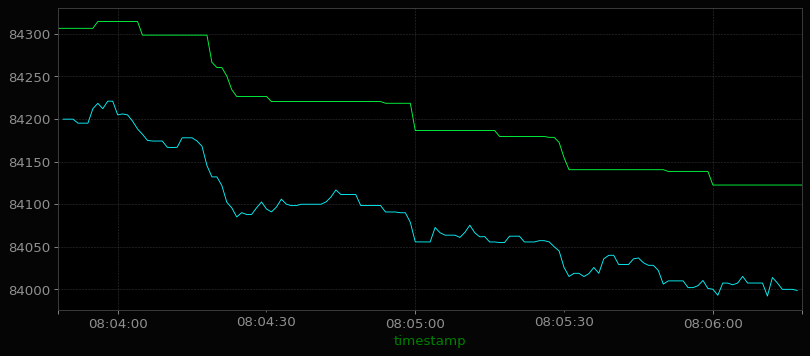

In [15]:
ctx.ohlc(ctx.instruments[0]).pd().close.plot();
ctx.ohlc(ctx.instruments[1]).pd().close.plot();

In [62]:
ctx.get_balances(exchange="KRAKEN.F")

{'USDT': AssetBalance(free=100000.0, locked=0.0, total=100000.0)}

In [74]:
ctx.trade(instr3, 1.0)

Order(id='SIM-ORDER-BTCUSD-100004', type='MARKET', instrument=KRAKEN.F:SWAP:BTCUSD, time=numpy.datetime64('2025-04-03T13:42:42.282391296'), quantity=1.0, price=0, side='BUY', status='CLOSED', time_in_force='gtc', client_id='qubx_BTCUSD_17436875922', cost=0.0, options={})

In [75]:
ctx.get_leverages(exchange="KRAKEN.F")

{KRAKEN.F:SWAP:BTCUSD: 0.0}

In [76]:
ctx.positions

{BINANCE.UM:SWAP:BTCUSDT: 2025-04-03 13:42:46 [BINANCE.UM:SWAP:BTCUSDT] qty=0.000 entryPrice=0.0 price=82340.1 PNL: (unrealized=0.00 realized=0.00 pnl=0.00) value=0.00,
 BITMEX:SWAP:BTCUSD: 2025-04-03 13:42:46 [BITMEX:SWAP:BTCUSD] qty=0.00 entryPrice=0.0 price=82312.7 PNL: (unrealized=0.00 realized=0.00 pnl=0.00) value=0.00,
 KRAKEN.F:SWAP:BTCUSD: 2025-04-03 13:42:46 [KRAKEN.F:SWAP:BTCUSD] qty=0.0000 entryPrice=0 price=82352 PNL: (unrealized=0.00 realized=-308.00 pnl=-308.00) value=0.00}

In [58]:
ctx.subscribe(DataType.TRADE)

In [59]:
ctx.get_data(instr3, DataType.TRADE)[-10:]

[[2025-04-03T13:37:51.151000000]	82320.00000 (0.06) buy ,
 [2025-04-03T13:37:51.183000000]	82320.00000 (0.07) buy ,
 [2025-04-03T13:37:51.193000000]	82320.00000 (0.06) buy ,
 [2025-04-03T13:37:54.408000000]	82304.00000 (0.06) sell ,
 [2025-04-03T13:37:54.427000000]	82299.00000 (0.06) sell ,
 [2025-04-03T13:37:54.929000000]	82289.00000 (0.04) sell ,
 [2025-04-03T13:37:54.984000000]	82278.00000 (0.01) sell ,
 [2025-04-03T13:37:55.061000000]	82275.00000 (0.01) sell ,
 [2025-04-03T13:37:55.061000000]	82275.00000 (0.01) sell ,
 [2025-04-03T13:37:55.235000000]	82257.00000 (0.01) sell ]

In [14]:
ctx.stop()

In [16]:
import ccxt.pro as cxp

bitfinex = cxp.bitfinex()
await bitfinex.load_markets();

In [17]:
res = bitfinex.has.get("watchOrderBookForSymbols", False)
if res:
    print("support")

In [ ]:
bitfinex.market("BTC/USDT:USDT")

In [10]:
await bitfinex.watch_bids_asks(["BTC/USD:USD"])

{'BTC/USD:USD': {'info': {'premium': 0.0,
   'product_id': 'PF_XBTUSD',
   'feed': 'ticker_lite',
   'bid': 82101.0,
   'ask': 82106.0,
   'change': -5.64,
   'volume': 7919.6894,
   'tag': 'perpetual',
   'pair': 'XBT:USD',
   'dtm': 0,
   'maturityTime': 0,
   'volumeQuote': 667229839.6259},
  'symbol': 'BTC/USD:USD',
  'timestamp': None,
  'datetime': None,
  'high': None,
  'low': None,
  'bid': 82101.0,
  'bidVolume': None,
  'ask': 82106.0,
  'askVolume': None,
  'vwap': 84249.49589890482,
  'open': None,
  'close': None,
  'last': None,
  'previousClose': None,
  'change': -5.64,
  'percentage': None,
  'average': None,
  'baseVolume': 7919.6894,
  'quoteVolume': 667229839.6259,
  'markPrice': None,
  'indexPrice': None}}

In [17]:
count = 0
try:
    while True:
        # quote = await bitfinex.watch_ticker("BTC/USDT:USDT")
        # print(f"Quote: {quote['bid']} ({quote['bidVolume']}) - {quote['ask']} ({quote['askVolume']})")
        ob = await bitfinex.watch_order_book("BTC/USDT:USDT")
        print(f"ob: {ob['bids']}")
        # quote = await bitfinex.watch_bids_asks(["BTC/USDT:USDT"])
        # print(f"Quote: {quote['bid']} ({quote['bidVolume']}) - {quote['ask']} ({quote['askVolume']})")
        count += 1
        if count > 5:
            break
except KeyboardInterrupt:
    pass


ob: [[81946.0, 0.00048812, 1.0], [81940.0, 0.0323, 1.0], [81938.0, 0.3608, 1.0], [81936.0, 0.0610402, 1.0], [81931.0, 0.0652, 2.0], [81930.0, 0.00048822, 1.0], [81929.0, 0.21905611, 1.0], [81928.0, 0.3608, 1.0], [81923.0, 0.29207481, 1.0], [81921.0, 0.1467712, 2.0], [81920.0, 0.14030226, 1.0], [81914.0, 0.36626672, 2.0], [81905.0, 0.4389341, 1.0], [81903.0, 0.6106457, 1.0], [81900.0, 0.24030226, 2.0], [81898.0, 0.00048841, 1.0], [81896.0, 0.98444, 1.0], [81892.0, 0.6107308, 1.0], [81888.0, 1.18934667, 2.0], [81887.0, 9.142e-05, 1.0], [81884.0, 0.6107854, 1.0], [81882.0, 0.0004885, 1.0], [81879.0, 0.58524546, 1.0], [81871.0, 0.65840115, 1.0], [81868.0, 1.68124482, 2.0]]
ob: [[81946.0, 0.00048812, 1.0], [81940.0, 0.0323, 1.0], [81936.0, 0.0610402, 1.0], [81931.0, 0.0652, 2.0], [81930.0, 0.00048822, 1.0], [81929.0, 0.21905611, 1.0], [81928.0, 0.3608, 1.0], [81923.0, 0.29207481, 1.0], [81921.0, 0.1467712, 2.0], [81920.0, 0.14030226, 1.0], [81914.0, 0.36626672, 2.0], [81905.0, 0.4389341, 1.

In [8]:
ob = await bitfinex.watch_order_book("BTC/USDT:USDT")

In [9]:
ob

{'bids': [[81847.0, 0.1516, 2.0], [81844.0, 0.3608, 1.0], [81841.0, 0.0001833, 1.0], [81840.0, 0.3608, 1.0], [81838.0, 0.16435388, 1.0], [81836.0, 0.09492, 1.0], [81835.0, 0.1278, 1.0], [81834.0, 0.00048879, 1.0], [81827.0, 0.6112723, 1.0], [81826.0, 1.5, 1.0], [81824.0, 0.00927511, 1.0], [81818.0, 0.69208889, 2.0], [81815.0, 0.6113653, 1.0], [81806.0, 0.005, 1.0], [81804.0, 0.98616, 1.0], [81802.0, 0.00048898, 1.0], [81800.0, 0.16435388, 1.0], [81798.0, 0.28931293, 1.0], [81795.0, 0.00183391, 1.0], [81789.0, 0.3620895, 1.0], [81786.0, 0.00048908, 1.0], [81783.0, 0.00932277, 1.0], [81780.0, 2.88156237, 2.0], [81770.0, 0.00048917, 1.0], [81765.0, 0.52619836, 2.0]],
 'asks': [[81875.0, 0.0004, 1.0], [81876.0, 0.00132, 1.0], [81880.0, 0.00895081, 1.0], [81881.0, 0.3608, 1.0], [81882.0, 0.09488, 1.0], [81888.0, 0.25445825, 1.0], [81891.0, 0.0004, 1.0], [81893.0, 0.3608, 1.0], [81895.0, 0.4176, 1.0], [81896.0, 0.29080943, 1.0], [81898.0, 0.98628, 1.0], [81900.0, 0.26435388, 2.0], [81907.0, 

In [ ]:
bitmex.market(instrument_to_ccxt_symbol(instr))

In [18]:
await bitfinex.close()

In [18]:
try:
    while True:
        trades = await bitmex.watch_trades_for_symbols(["BTC/USDT:USDT"])
        for trade in trades:
            print(trade)
except KeyboardInterrupt:
    pass

{'info': {'timestamp': '2025-04-03T13:25:24.568Z', 'symbol': 'XBTUSDT', 'side': 'Buy', 'size': 58500, 'price': 81949.9, 'tickDirection': 'PlusTick', 'trdMatchID': '00000000-006d-1000-0000-0015cc7cedb2', 'grossValue': 4794069150, 'homeNotional': 0.0585, 'foreignNotional': 4794.06915, 'trdType': 'Regular'}, 'timestamp': 1743686724568, 'datetime': '2025-04-03T13:25:24.568Z', 'symbol': 'BTC/USDT:USDT', 'id': '00000000-006d-1000-0000-0015cc7cedb2', 'order': None, 'type': None, 'takerOrMaker': None, 'side': 'buy', 'price': 81949.9, 'cost': 4794.06915, 'amount': 58500.0, 'fee': {'cost': None, 'currency': None}, 'fees': []}
{'info': {'timestamp': '2025-04-03T13:25:36.051Z', 'symbol': 'XBTUSDT', 'side': 'Buy', 'size': 400, 'price': 81942.0, 'tickDirection': 'MinusTick', 'trdMatchID': '00000000-006d-1000-0000-0015cc7dae27', 'grossValue': 32776800, 'homeNotional': 0.0004, 'foreignNotional': 32.7768, 'trdType': 'Regular'}, 'timestamp': 1743686736051, 'datetime': '2025-04-03T13:25:36.051Z', 'symbol

CancelledError: 

In [64]:
from qubx.connectors.ccxt.utils import ccxt_convert_trade
ccxt_convert_trade(trades[0])

[2025-04-03T13:20:38.069000000]	81863.70000 (10000.00) buy 